<a href="https://colab.research.google.com/github/baseer23/t5-disfluency-rewriter/blob/main/T5_Disfluency_Cleaner_E2E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA) of Disfl-QA Dataset

This notebook performs an in-depth Exploratory Data Analysis on the Disfl-QA dataset, which contains pairs of disfluent and fluent questions. The goal is to understand the characteristics of the data, identify potential issues, and prepare the dataset for training a sequence-to-sequence model for disfluency removal.

## Data Loading and Structuring
Loading the raw JSON data from Google Drive and converting it into structured pandas DataFrames for easier manipulation and analysis.

In [2]:
import json
import pandas as pd

# Paths to the dataset in drive (replace with your actual paths if different)
train_path = '/content/drive/MyDrive/disflqa/data/train.json'
dev_path = '/content/drive/MyDrive/disflqa/data/dev.json'

# Load JSON files
with open(train_path, 'r') as f:
    train_data = json.load(f)
with open(dev_path, 'r') as f:
    dev_data = json.load(f)

# Convert dictionaries to DataFrames (ID becomes index)
df_train = pd.DataFrame.from_dict(train_data, orient='index')
df_dev = pd.DataFrame.from_dict(dev_data, orient='index')

# Rename columns for clarity
df_train.rename(columns={"original": "fluent_question", "disfluent": "disfluent_question"}, inplace=True)
df_dev.rename(columns={"original": "fluent_question", "disfluent": "disfluent_question"}, inplace=True)

# Reset index to drop the SQuAD IDs (not needed for EDA)
df_train.reset_index(drop=True, inplace=True)
df_dev.reset_index(drop=True, inplace=True)

print("Train shape:", df_train.shape)
print("Dev shape:", df_dev.shape)
df_train.head(3)

Train shape: (7182, 2)
Dev shape: (1000, 2)


,fluent_question,disfluent_question
0,What do unstable isotope studies indicate?,What do petrologists no what do unstable isoto...
1,What is the basic unit of territorial division...,What is the second level of territorial divisi...
2,Which genus lack tentacles and sheaths?,Juvenile platyctenids no wow Which genus lack ...


## Data Verification and Cleaning
Initial checks on the dataset to understand its structure, identify missing values, and clean inconsistencies or errors. This includes removing corrupted entries, correcting typos, stripping whitespace, and ensuring consistent question formatting.

In [3]:
# Check for missing values and column types
df_train.info()
print("\nAny nulls in train?\n", df_train.isnull().sum())

# Quick sample of pairs
for i in range(3):
    print(f"Disfluent: {df_train.disfluent_question[i]}")
    print(f"Fluent:    {df_train.fluent_question[i]}")
    print("---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   fluent_question     7182 non-null   object
 1   disfluent_question  7182 non-null   object
dtypes: object(2)
memory usage: 112.3+ KB

Any nulls in train?
 fluent_question       0
disfluent_question    0
dtype: int64
Disfluent: What do petrologists no what do unstable isotope studies indicate?
Fluent:    What do unstable isotope studies indicate?
---
Disfluent: What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?
Fluent:    What is the basic unit of territorial division in Warsaw?
---
Disfluent: Juvenile platyctenids no wow Which genus lack tentacles and sheaths?
Fluent:    Which genus lack tentacles and sheaths?
---


In [4]:
# Find any instances of "#VALUE!" in disfluent questions
mask_value_errors = df_train.disfluent_question.str.contains("#VALUE!", na=False)
print("Disfluent entries with '#VALUE!':", mask_value_errors.sum())
df_train[mask_value_errors].head()

Disfluent entries with '#VALUE!': 18


,fluent_question,disfluent_question
556,How is packet switching characterized,#VALUE!
867,How are Air force messages delivered,#VALUE!
942,What did this concept contradict,#VALUE!
1482,Telnet Used what Interface technology,#VALUE!
2133,What 3 things does the Air Force work key on,#VALUE!


In [5]:
# Check for exact matches between disfluent and fluent questions
exact_matches = (df_train.disfluent_question == df_train.fluent_question).sum()
print("Pairs where disfluent == fluent:", exact_matches)

Pairs where disfluent == fluent: 2


## Vocabulary and Length Analysis
Analyzing the vocabulary size and the distribution of question lengths for both fluent and disfluent questions. This helps in understanding the linguistic complexity and the impact of disfluencies on sentence length and word usage. Specific disfluency markers are also identified and analyzed.

In [6]:
# Vocabulary size analysis
flu_words = set(" ".join(df_train.fluent_question).split())
disflu_words = set(" ".join(df_train.disfluent_question).split())
print("Unique words in fluent questions:", len(flu_words))
print("Unique words in disfluent questions:", len(disflu_words))
print("New words introduced by disfluencies:", len(disflu_words - flu_words))

Unique words in fluent questions: 10577
Unique words in disfluent questions: 12431
New words introduced by disfluencies: 2303


In [7]:
# Compute word counts for each question
df_train['fluent_word_count'] = df_train.fluent_question.str.split().apply(len)
df_train['disfluent_word_count'] = df_train.disfluent_question.str.split().apply(len)

# Summary statistics for word counts
print(df_train[['fluent_word_count','disfluent_word_count']].describe().T)

                       count       mean       std  min   25%   50%   75%   max
fluent_word_count     7182.0   9.830409  3.369577  3.0   7.0   9.0  12.0  29.0
disfluent_word_count  7182.0  14.523810  4.554876  0.0  11.0  14.0  17.0  82.0


In [8]:
# Calculate the average and max difference in word counts
length_diff = df_train.disfluent_word_count - df_train.fluent_word_count
print("Average extra words due to disfluency:", length_diff.mean())
print("Max extra words due to disfluency:", length_diff.max())

Average extra words due to disfluency: 4.693400167084378
Max extra words due to disfluency: 73


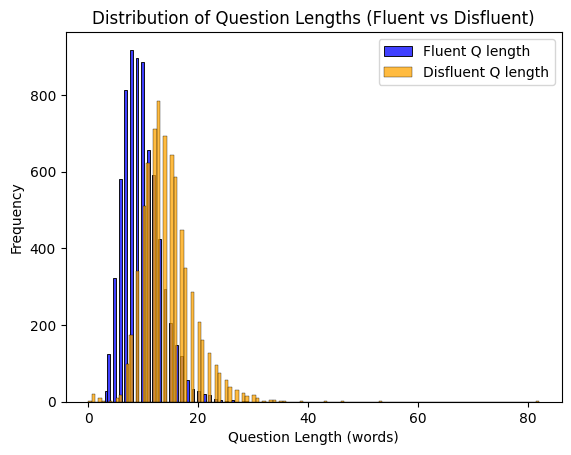

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of question lengths
sns.histplot(df_train.fluent_word_count, color='blue', label='Fluent Q length', kde=False)
sns.histplot(df_train.disfluent_word_count, color='orange', label='Disfluent Q length', kde=False)
plt.xlabel("Question Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Question Lengths (Fluent vs Disfluent)")
plt.legend()
plt.show()

In [10]:
from collections import Counter

# Flatten tokens and compute word frequencies
flu_tokens = " ".join(df_train.fluent_question).split()
disflu_tokens = " ".join(df_train.disfluent_question).split()

flu_freq = Counter(flu_tokens)
disflu_freq = Counter(disflu_tokens)

# Print top 20 most common words
print("Top 20 words in fluent questions:")
print(flu_freq.most_common(20))
print("\nTop 20 words in disfluent questions:")
print(disflu_freq.most_common(20))

Top 20 words in fluent questions:
[('the', 4837), ('What', 3458), ('of', 2658), ('in', 1578), ('is', 1498), ('to', 1479), ('was', 1046), ('did', 1045), ('a', 965), ('what', 735), ('How', 681), ('are', 619), ('Who', 618), ('and', 583), ('for', 510), ('does', 492), ('When', 490), ('do', 423), ('that', 411), ('many', 392)]

Top 20 words in disfluent questions:
[('the', 6323), ('no', 4083), ('What', 3196), ('of', 3048), ('what', 2260), ('in', 1929), ('is', 1909), ('to', 1747), ('or', 1745), ('was', 1459), ('did', 1452), ('that', 1233), ('a', 1164), ('How', 895), ('I', 877), ('are', 815), ('rather', 712), ('sorry', 693), ('does', 682), ('and', 672)]


In [11]:
# Identify words unique to disfluent questions and disproportionately frequent words
disflu_only = disflu_freq.keys() - flu_freq.keys()
print("Words that appear only in disfluent questions (not in any fluent):", disflu_only)

# Calculate ratio of frequencies for common words in disfluent vs fluent questions
ratio = {}
for word, df_count in disflu_freq.items():
    f_count = flu_freq.get(word, 0)
    # Only consider words that appear at least, say, 5 times in disfluent
    if df_count >= 5:
        # If fluent count is zero, set a high ratio manually
        ratio[word] = df_count / (f_count + 1)
# Sort by ratio or difference
top_disflu_words = sorted(ratio.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top disproportionate disfluency words:", top_disflu_words)

Words that appear only in disfluent questions (not in any fluent): {'Albany', 'polls,', '1962', 'achieved', 'plans,', 'phillippines?', 'Afghanistan,', 'inequality,', 'pre-2004', 'inputs?', '$100,000,', 'Century\\"?', 'Burma', 'formalized', 'played?', '\\"Dream', 'volcanos', 'now,', 'limited,', 'Revival', 'approved,', 'geographer', 'mechanics,', 'Preparatory', 'theymus', 'alumni,', 'sleep?', 'homeless', '2016,', 'woah', 'blood\\u2013brain', 'stylistically,', 'Fami', 'Zulfiqar,', 'Upper?', 'Arts', 'encouraged,', 'Times,', 'no,', 'Cedar', 'globalization', 'Alter', 'Strasbourg', 'reformulate', 'oop,', 'issues?', 'Taliban?', 'cnidarian', '1756', 'acutally', 'Storybook', 'yikes', 'tradition', 'unearned', 'independance', 'Tymnet?', 'arrives', 'Arabs\\"?', 'larger?', 'be,', 'integrity?', 'hoping', 'tissue', 'lowest?', 'ah', "Years'", 'baltic', 'capital,', 'abolitionist', 'further?', 'krill', 'uh1701?', 'Lorelei,', 'NK,', 'nutrients,', 'Southeastern', 'Williard', 'GR', 'understate', 'anti..', '

In [12]:
# Check frequencies of selected disfluency markers
markers = ["no", "I", "mean", "sorry", "uh", "um", "oops", "ugh", "rather", "actually", "scratch", "make"]
for m in markers:
    print(f"'{m}': fluent={flu_freq.get(m,0)}, disfluent={disflu_freq.get(m,0)}")

'no': fluent=53, disfluent=4083
'I': fluent=10, disfluent=877
'mean': fluent=11, disfluent=649
'sorry': fluent=0, disfluent=693
'uh': fluent=0, disfluent=590
'um': fluent=0, disfluent=368
'oops': fluent=0, disfluent=95
'ugh': fluent=0, disfluent=33
'rather': fluent=5, disfluent=712
'actually': fluent=5, disfluent=269
'scratch': fluent=0, disfluent=83
'make': fluent=41, disfluent=671


## Data Visualization
Visualizing the distribution of question lengths and the frequency of disfluency markers to gain better insights into the data characteristics.

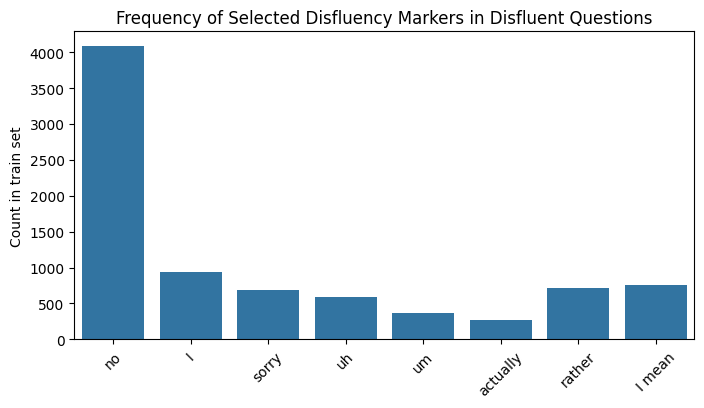

In [13]:
import matplotlib.pyplot as plt

# Plot frequency of selected disfluency markers
common_markers = ["no", "I", "sorry", "uh", "um", "actually", "rather", "I mean"]
counts = []
for token in common_markers:
    # For bigrams like "I mean", count occurrences of the phrase in all disfluent questions
    if " " in token:
        counts.append(df_train.disfluent_question.str.contains(token).sum())
    else:
        counts.append(sum(1 for word in disflu_tokens if word.strip().lower()==token.lower()))
plt.figure(figsize=(8,4))
sns.barplot(x=common_markers, y=counts)
plt.title("Frequency of Selected Disfluency Markers in Disfluent Questions")
plt.ylabel("Count in train set")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Drop entries with "#VALUE!" in disfluent questions
mask_bad = df_train.disfluent_question == "#VALUE!"
bad_count = mask_bad.sum()
df_train = df_train[~mask_bad].copy()
print(f"Dropped {bad_count} bad entries from training set.")

Dropped 18 bad entries from training set.


In [15]:
# Drop entries with "#VALUE!" in disfluent questions from development set
mask_bad_dev = df_dev.disfluent_question == "#VALUE!"
bad_count_dev = mask_bad_dev.sum()
df_dev = df_dev[~mask_bad_dev].copy()
print(f"Dropped {bad_count_dev} bad entries from development set.")

Dropped 3 bad entries from development set.


In [16]:
# Correct typo "rahter" to "rather" in disfluent questions
df_train['disfluent_question'] = df_train.disfluent_question.str.replace("rahter", "rather")
df_dev['disfluent_question'] = df_dev.disfluent_question.str.replace("rahter", "rather")

In [17]:
# Strip leading/trailing whitespace from questions
df_train['fluent_question'] = df_train.fluent_question.str.strip()
df_train['disfluent_question'] = df_train.disfluent_question.str.strip()
df_dev['fluent_question'] = df_dev.fluent_question.str.strip()
df_dev['disfluent_question'] = df_dev.disfluent_question.str.strip()

In [18]:
# Add '?' to disfluent questions that lack it
mask_qmark = ~df_train.disfluent_question.str.endswith('?')
print("Disfluent questions missing '?':", mask_qmark.sum())
df_train.loc[mask_qmark, 'disfluent_question'] += '?'

Disfluent questions missing '?': 56


In [19]:
# Drop duplicate rows based on fluent and disfluent questions
before = len(df_train)
df_train.drop_duplicates(subset=['fluent_question', 'disfluent_question'], inplace=True)
after = len(df_train)
print(f"Dropped {before-after} duplicate rows (if any).")

Dropped 0 duplicate rows (if any).


In [20]:
# Recalculate dataset sizes and show a cleaned example
print("Final training size:", len(df_train), "Final dev size:", len(df_dev))
print("Examples of cleaned disfluent text fixes:")
print(df_train[df_train.disfluent_question.str.contains("rather")].disfluent_question.iloc[0])

Final training size: 7164 Final dev size: 997
Examples of cleaned disfluent text fixes:
What is the name of the number theory, or rather, the supposition that any number larger than 2 can be represented as the sum of two primes?


## Data Augmentation (Rule-Based)
Implementing a rule-based approach to augment the training data by introducing synthetic disfluencies. This helps in increasing the dataset size and exposing the model to a wider variety of disfluent patterns.

In [21]:
import random

WH_WORDS = ["What", "Who", "Where", "When", "Why", "How"]

def augment_question(fluent_q):
    """Return an artificially disfluent version of the fluent question."""
    words = fluent_q.split()
    if not words:
        return fluent_q  # safety

    # 50% chance to do a WH-word restart if question begins with WH-word
    if words[0] in WH_WORDS:
        # choose a different WH word randomly
        alt_wh = random.choice([w for w in WH_WORDS if w != words[0]])
        # e.g., "Who did ... ? no, [original question]"
        disfluent = f"{alt_wh} {' '.join(words[1:])} no, {fluent_q}"
    else:
        disfluent = fluent_q

    # 50% chance to inject an "uh" at a random position (not at very end)
    if len(disfluent.split()) > 3:  # only if question is long enough
        tokens = disfluent.split()
        pos = random.randrange(1, len(tokens))  # after at least one word
        tokens.insert(pos, "uh")  # insert filler
        disfluent = " ".join(tokens)

    # Ensure it ends with '?'
    if not disfluent.endswith('?'):
        disfluent = disfluent.rstrip('.') + '?'
    return disfluent

# Test augmentation on a couple of fluent questions
for q in ["What is the capital of France?",
          "Who wrote the novel 1984?",
          "The Tower District is centered around which historic theatre?"]:
    print("Original:", q)
    print("Augmented:", augment_question(q))

Original: What is the capital of France?
Augmented: When is the uh capital of France? no, What is the capital of France?
Original: Who wrote the novel 1984?
Augmented: When wrote the novel 1984? no, Who uh wrote the novel 1984?
Original: The Tower District is centered around which historic theatre?
Augmented: The Tower District is uh centered around which historic theatre?


In [22]:
# Augment each train pair once
augmented_pairs = []
for fq in df_train.fluent_question:
    dq_aug = augment_question(fq)
    augmented_pairs.append((dq_aug, fq))
print(f"Generated {len(augmented_pairs)} augmented disfluent questions.")

# Convert to DataFrame and combine with original training data
df_aug = pd.DataFrame(augmented_pairs, columns=["disfluent_question", "fluent_question"])
df_train_augmented = pd.concat([df_train, df_aug], ignore_index=True)
print("Augmented training set size:", len(df_train_augmented))

Generated 7164 augmented disfluent questions.
Augmented training set size: 14328


In [23]:
# Display the tail of the augmented training set
df_train_augmented.tail(3)

,fluent_question,disfluent_question,fluent_word_count,disfluent_word_count
14325,When did Li Tan reject a revolt?,"How did uh Li Tan reject a revolt? no, When di...",NaN,NaN
14326,What was there a significant minority of in Wo...,Where was there a significant minority of in W...,NaN,NaN
14327,How long after a banquet with Tugh Temur did K...,When long after a banquet with Tugh Temur did ...,NaN,NaN


## Exporting Cleaned and Augmented Data
Saving the cleaned and augmented datasets to CSV files for easy access and use in subsequent modeling steps.

In [24]:
# Save cleaned and augmented dataframes to CSV files
df_train.to_csv("/content/drive/MyDrive/disflqa/data/train_clean.csv", index=False)
df_dev.to_csv("/content/drive/MyDrive/disflqa/data/dev_clean.csv", index=False)
df_train_augmented.to_csv("/content/drive/MyDrive/disflqa/data/train_clean_augmented.csv", index=False)

print("Train set (clean) size:", len(df_train), "Dev set size:", len(df_dev))

Train set (clean) size: 7164 Dev set size: 997


In [25]:
# Install required libraries
!pip install transformers datasets evaluate[sacrebleu] -U

In [26]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import TrainingArguments, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
from datasets import load_dataset # Import load_dataset here
import evaluate

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [27]:
# Define the paths to the processed CSV files and load the datasets
data_files = {
    "train": "/content/drive/MyDrive/disflqa/data/train_clean_augmented.csv",
    "validation": "/content/drive/MyDrive/disflqa/data/dev_clean.csv"
}
dataset = load_dataset("csv", data_files=data_files)
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['fluent_question', 'disfluent_question', 'fluent_word_count', 'disfluent_word_count'],
        num_rows: 14328
    })
    validation: Dataset({
        features: ['fluent_question', 'disfluent_question', 'fluent_word_count', 'disfluent_word_count'],
        num_rows: 997
    })
})


In [28]:
# List files in the data directory
!ls /content/drive/MyDrive/disflqa/data/

dev_clean.csv  test.json		  train_clean.csv
dev.json       train_clean_augmented.csv  train.json


In [29]:
# Peek at an example from the training set
print(dataset["train"][0])

{'fluent_question': 'What do unstable isotope studies indicate?', 'disfluent_question': 'What do petrologists no what do unstable isotope studies indicate?', 'fluent_word_count': 6.0, 'disfluent_word_count': 10.0}


## Tokenization and Preprocessing
This section prepares the dataset for training the T5 model. Disfluent and fluent questions are tokenized, and padding/truncation is applied to ensure uniform sequence lengths. The `preprocess_function` handles the conversion of text pairs into tokenized input and label IDs for the model.

In [30]:
# Initialize the T5 tokenizer (SentencePiece model)
tokenizer = T5Tokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [31]:
MAX_LEN = 64  # maximum tokens per sequence (you can adjust based on EDA results)

def preprocess_function(batch):
    """Tokenize the input and target sequences."""
    # Tokenize the disfluent question (input)
    model_inputs = tokenizer(batch["disfluent_question"],
                              max_length=MAX_LEN, truncation=True)
    # Tokenize the fluent question (target) as the labels
    with tokenizer.as_target_tokenizer():  # ensure the tokenizer knows we're processing target text
        labels = tokenizer(batch["fluent_question"],
                            max_length=MAX_LEN, truncation=True)
    # Store the tokenized labels in the model inputs dictionary with key "labels"
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing to the entire dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/14328 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/997 [00:00<?, ? examples/s]

In [32]:
# Print keys and example token IDs
print(tokenized_dataset["train"][0].keys())
# Expected output: dict_keys(['disfluent_question', 'fluent_question', 'input_ids', 'attention_mask', 'labels'])
print(tokenized_dataset["train"][0]["input_ids"][:10])  # first 10 token ids of input
print(tokenized_dataset["train"][0]["labels"][:10])     # first 10 token ids of target

dict_keys(['fluent_question', 'disfluent_question', 'fluent_word_count', 'disfluent_word_count', 'input_ids', 'attention_mask', 'labels'])
[363, 103, 3947, 52, 17382, 150, 125, 103, 27644, 19]
[363, 103, 27644, 19, 32, 2916, 15, 2116, 6360, 58]


In [33]:
# Decode an example input to verify tokenization
ids = tokenized_dataset["train"][0]["input_ids"]
print(tokenizer.decode(ids))

What do petrologists no what do unstable isotope studies indicate?</s>


In [34]:
# Load the pre-trained T5-base model for sequence-to-sequence generation
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
model.to(device)  # move model to GPU if available

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [35]:
# Initialize the data collator for sequence-to-sequence tasks
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

## Model and Trainer Initialization
Here, the T5-base model for sequence-to-sequence generation is loaded and moved to the appropriate device (GPU if available). The `DataCollatorForSeq2Seq` is initialized to handle padding during training and evaluation. The `Seq2SeqTrainer` is set up with the model, tokenized datasets, and training arguments defined in the previous step. Early stopping is added to monitor the evaluation metric (BLEU) and prevent overfitting.

In [36]:
batch_size = 16  # Try bumping to 16 if Colab GPU memory allows (mixed precision fp16=True helps). If OOM, keep 8 but use gradient_accumulation_steps=2 to simulate 16.
epochs = 5      # Instead of fixed 3 epochs, set num_train_epochs=5 with early stopping (patience=2).

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_disfluent_cleaner",       # where to save model checkpoints
    eval_strategy="epoch",             # evaluate on the validation set each epoch
    save_strategy="epoch",                   # save a checkpoint each epoch
    learning_rate=2e-5,                      # initial learning rate, start with 2e-5, but can try a small sweep (1e-4, 5e-5, 2e-5)
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,                       # weight decay for regularization
    predict_with_generate=True,              # use generate() to get predictions for eval
    logging_steps=50,                        # log training metrics every 50 steps
    save_total_limit=2,                      # only keep the 2 most recent checkpoints
    load_best_model_at_end=True,             # load the best model found (according to metric) at end of training
    metric_for_best_model="bleu",            # metric to use to compare model checkpoints
    greater_is_better=True,                  # higher BLEU is better
    fp16=True,                               # enable mixed precision for faster training if supported by GPU
    warmup_steps=500,                        # Add warmup_steps=500 — helps stabilize T5’s training early on.
    label_smoothing_factor=0.1,              # Set label_smoothing_factor=0.1 to prevent overconfidence and slightly boost generalization.
    generation_num_beams=4                   # During training eval, set num_beams=4 for predict_with_generate=True
)

In [37]:
# Initialize the Trainer with our model, data, and training configs
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None  # we'll set up separately below
)

# Add Early Stopping
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

/tmp/ipython-input-3312726520.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [38]:
# Install rouge_score library for ROUGE metric computation
!pip install rouge_score

## Metric Computation
This section defines the `compute_metrics` function used during training evaluation. It calculates BLEU, ROUGE-L, and Exact Match scores by decoding the model's predictions and comparing them to the reference labels. BLEU is the primary metric for model selection as it best reflects rewrite accuracy. The function includes handling for potential invalid token IDs in the predictions.

In [39]:
import nltk
# Download punkt_tab for sentence tokenization in ROUGE computation
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [40]:
import numpy as np
import nltk
nltk.download('punkt', quiet=True)  # for sentence tokenization in ROUGE

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
exact_match_metric = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    """Computes evaluation metrics (BLEU, ROUGE-L, Exact Match)."""
    predictions, label_ids = eval_pred
    # Replace -100 in labels as we've to ignore padding in labels for decoding
    label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)

    # Replace any prediction IDs outside the valid range with the padding token ID
    vocab_size = tokenizer.vocab_size
    predictions = np.where((predictions < 0) | (predictions >= vocab_size), tokenizer.pad_token_id, predictions)

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    # Strip any leading/trailing whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # BLEU expects a list of predictions (strings) and a list of list of references (strings)
    bleu_result = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

    # ROUGE - compute aggregate scores for ROUGE-1,2,L
    # Prepare text by sentence for rougeL (important for proper scoring)
    decoded_preds_sent = ["\n".join(nltk.sent_tokenize(pred)) for pred in decoded_preds]
    decoded_labels_sent = ["\n".join(nltk.sent_tokenize(label)) for label in decoded_labels]
    rouge_result = rouge.compute(predictions=decoded_preds_sent, references=decoded_labels_sent, use_stemmer=True)

    # Access ROUGE-L F1 score, handling potential different return types
    rougeL_score = rouge_result["rougeL"]
    if hasattr(rougeL_score, 'mid'):
        rougeL_score = rougeL_score.mid.fmeasure

    # Exact match
    em_result = exact_match_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Format the metrics nicely
    metrics = {
        "bleu": bleu_result["bleu"],              # BLEU score (0 to 1)
        "rougeL": rougeL_score,                   # ROUGE-L F1 score (0 to 1)
        "exact_match": em_result["exact_match"]   # Exact match percentage (0 to 100)
    }
    return metrics

# Update the trainer to use the compute_metrics function
trainer.compute_metrics = compute_metrics

## Training the Model
The model is trained using the `trainer.train()` method with the configured training arguments and the augmented dataset. Training progress, including evaluation metrics (BLEU, ROUGE-L, Exact Match), is logged and tracked. Early stopping will automatically halt training if the validation BLEU score does not improve.

In [42]:
# Train the model
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Rougel,Exact Match
1,1.652000,1.679002,0.898867,0.952972,0.703109
2,1.616400,1.654351,0.903892,0.955382,0.718154
3,1.584400,1.644301,0.905455,0.956556,0.725176
4,1.596300,1.639439,0.908773,0.958422,0.734203
5,1.600500,1.637505,0.907670,0.957985,0.734203


Epoch,Training Loss,Validation Loss


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


## Evaluating the Trained Model
After training, the model is explicitly evaluated on the validation set using `trainer.evaluate()` to obtain the final performance metrics.

In [43]:
# Evaluate on the validation set
metrics = trainer.evaluate()
print("Final evaluation metrics:", metrics)

Final evaluation metrics: {'eval_loss': 1.6394389867782593, 'eval_bleu': 0.9087729363921471, 'eval_rougeL': 0.9584224269361643, 'eval_exact_match': 0.7342026078234705, 'eval_runtime': 71.5836, 'eval_samples_per_second': 13.928, 'eval_steps_per_second': 0.88, 'epoch': 5.0}


## Generating Predictions on Validation Examples
This section demonstrates how to use the fine-tuned model to generate fluent questions from disfluent input. A few examples from the validation set are used to show the model's output compared to the target fluent questions.

In [44]:
# Generate predictions on a few validation examples
import random
indices = random.sample(range(len(dataset["validation"])), 3)

for i in indices:
    disfluent_q = dataset["validation"][i]["disfluent_question"]
    target = dataset["validation"][i]["fluent_question"]
    # Tokenize the input (add batch dimension and send to device)
    inputs = tokenizer(disfluent_q, return_tensors="pt").to(device)
    # Generate output (using beam search by default of T5)
    outputs = model.generate(**inputs, max_length=MAX_LEN)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\nDisfluent: {disfluent_q}\nPredicted Clean: {pred}\nTarget Clean: {target}\n")


Disfluent: How many students enrolled at the College during the spring of 2011, actually, in 2014?
Predicted Clean: How many students enrolled at the College during the spring of 2014?
Target Clean: How many students enrolled at the College during the spring of 2014?


Disfluent: What has or instead what do weak labor movement correlate with?
Predicted Clean: What do weak labor movement correlate with?
Target Clean: What do weak labor movement correlate with?


Disfluent: Which or no make that what type of committee is set down under the SP's standing orders?
Predicted Clean: What type of committee is set down under the SP's standing orders?
Target Clean: What type of committee is set down under the SP's standing orders?



## Saving and Pushing Model to Hugging Face Hub
Saving the trained model and tokenizer locally and then pushing them to the Hugging Face Hub. This makes the model easily accessible for future use and allows for a clean, standalone inference notebook without including training code. This separation of training and inference code is good practice for deployment and evaluation.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...t/t5_disfluent_cleaner/spiece.model: 100%|##########|  792kB /  792kB            

  ...disfluent_cleaner/model.safetensors:   0%|          |  552kB /  892MB            

  ...ents.1754105044.b884da680422.1844.0:  20%|#9        | 5.95kB / 30.2kB            

  ...ents.1754106949.b884da680422.1844.1:  20%|#9        |   101B /   512B            

  ...ents.1754108443.b884da680422.1844.2:  20%|#9        | 2.38kB / 12.1kB            

  ...nts.1754109024.b884da680422.20143.0:  20%|#9        | 7.24kB / 36.7kB            

  ...nts.1754111262.b884da680422.20143.1:  20%|#9        |   101B /   512B            

  ...disfluent_cleaner/training_args.bin:  20%|#9        | 1.08kB / 5.50kB            

CommitInfo(commit_url='https://huggingface.co/abdulbaseermohammedkhan/t5_disfluent_cleaner/commit/29c75de6065cdf06d919cf67134ae47ae2e206f6', commit_message='End of training', commit_description='', oid='29c75de6065cdf06d919cf67134ae47ae2e206f6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abdulbaseermohammedkhan/t5_disfluent_cleaner', endpoint='https://huggingface.co', repo_type='model', repo_id='abdulbaseermohammedkhan/t5_disfluent_cleaner'), pr_revision=None, pr_num=None)

## Inference with the Trained Model
Loading the fine-tuned model and tokenizer from the Hugging Face Hub to perform inference on the test dataset. The model will generate fluent questions from the disfluent questions in the test set.

In [ ]:
# Install required packages if running locally
try:
    import transformers
    import torch
except ImportError:
    !pip install transformers torch


In [54]:
import pandas as pd
import torch
from transformers import T5Tokenizer, AutoModelForSeq2SeqLM
import json # Keep import in case user wants to load JSON data later

# Define the model name on Hugging Face Hub
model_name = "abdulbaseermohammedkhan/t5_disfluent_cleaner"

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model loaded and moved to {device}")

# Define sample disfluent questions
sample_disfluent_questions = [
    "What do petrologists no what do unstable isotope studies indicate?",
    "What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?",
    "Juvenile platyctenids no wow Which genus lack tentacles and sheaths?",
]

print(f"\nRunning inference on {len(sample_disfluent_questions)} sample questions:")

# Generate predictions for sample questions
original_disfluent = []
predicted_fluent = []

# Set model to evaluation mode
model.eval()

with torch.no_grad(): # Disable gradient calculation for inference
    for disfluent_q in sample_disfluent_questions:
        original_disfluent.append(disfluent_q)

        # Tokenize the input
        inputs = tokenizer(disfluent_q, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)

        # Generate output
        # Using num_beams=4 as decided during training evaluation
        outputs = model.generate(**inputs, max_length=64, num_beams=4, early_stopping=True)

        # Decode the output
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted_fluent.append(pred)

# Display the original and predicted questions
print("\nOriginal Disfluent Questions and Predicted Fluent Questions:")
for i in range(len(original_disfluent)):
    print(f"Original: {original_disfluent[i]}")
    print(f"Predicted: {predicted_fluent[i]}")
    print("-" * 20)



Model loaded and moved to cuda

Running inference on 3 sample questions:

Original Disfluent Questions and Predicted Fluent Questions:
Original: What do petrologists no what do unstable isotope studies indicate?
Predicted: What do unstable isotope studies indicate?
--------------------
Original: What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?
Predicted: What is the basic unit of territorial division in Warsaw?
--------------------
Original: Juvenile platyctenids no wow Which genus lack tentacles and sheaths?
Predicted: Which genus lack tentacles and sheaths?
--------------------
